# 模拟合约对于Uni的对冲作用

In [13]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'notebook'

In [14]:
# 模拟币本位合约盈亏

# 生成价格序列
def gen_price_series(start_price, end_price, n):
    price_series = [start_price]
    interval = (end_price - start_price) / n
    for i in range(n):
        price_series.append(price_series[i] + interval)
    return price_series

# 计算盈亏
def calc_bi_pnl(open, close,direction,contract_value):
    return (1/open - 1/close) * direction * contract_value
def calc_u_pnl(open, close,direction,contract_value):
    return (close - open)/open * direction * contract_value
    

In [15]:
import math
p2 = 2000
sigma = 0.05
p0 = p2 * (1-sigma)
p1 = p2 * (1+sigma)

q96 = 1 
a0 = 25
a1 = 50000

sqrtp0 = (math.sqrt(p0)* q96)
sqrtp1 = (math.sqrt(p1)* q96)
sqrtp2 = (math.sqrt(p2)* q96)

liq0 = a0 * (sqrtp2 * sqrtp1) / q96 / (sqrtp1 - sqrtp2)
liq1 = a1 * q96 / (sqrtp2 - sqrtp0)
liq = min(liq0, liq1)
print("liq is: ", liq)

rx = liq * q96 * (sqrtp1 - sqrtp2) / (sqrtp2 * sqrtp1)
ry = liq * (sqrtp2 - sqrtp0) / q96
print("rx is: ", rx)
print("ry is :", ry)

liq is:  44155.17449270128
rx is:  23.794815160510563
ry is : 50000.0


In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 定义函数f(p1, a)
def f(p1, a):
    # 这里定义函数f的具体表达式
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq + (1/p0 - 1/p1) * a
# 定义方差函数

def f1(p1,a):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq + (p0 - p1) * a/p0

def IL(p1,a):
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq * p1 + (p1 ** 0.5 - p0 ** 0.5) * liq

def f_all(p1,b,c):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq + (p0 - p1) * c/p0 + ((1/p1**0.5 - 1/p0**0.5)*liq + (1/p0 - 1/p1) * b) * p1


def f_c(p1, b):
    p0 = 2000
    return (1/p0 - 1/p1) * b * p1

def f_u(p1, b):
    p0 = 2000
    return (p0 - p1) * b/p0

def get_p1_values():
    return np.linspace(p0, p1, 1000)

def variance(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f(p1, b) for p1 in p1_values])
    return var

def variance1(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f1(p1, b) for p1 in p1_values])
    return var

def variance_all(x0):
    p1_values = get_p1_values()
    var = np.var([f_all(p1,x0[0],x0[1]) for p1 in p1_values])
    return var


# # 设置初始猜测值
# initial_guess_all = (10,705)
# initial_guess = 10
# # 最小化方差函数
# result = minimize(variance, initial_guess)
# result1 = minimize(variance1, initial_guess)
# result_all = minimize(variance_all, initial_guess_all)
# # 输出最小化方差的最优解
# optimal_b = result.x[0]
# print("Optimal value of b:", optimal_b)
# # 输出最小化方差的最优解
# optimal_b1 = result1.x[0]
# print("Optimal value of b1:", optimal_b1)

# # 输出最小化方差的最优解
# optimal_b_all = result_all.x[0]
# optimal_c_all = result_all.x[1]
# print("Optimal value of b_all:", optimal_b_all, "Optimal value of c_all:", optimal_c_all)
# # 杠杆倍数
# print("Optimal leverage:", optimal_b / 100000)


d:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1



In [17]:
# 计算Pnl
pnl = [f(p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()]
pnl1 = [f1(p1, liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()]

In [18]:
def dy(p1):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq

def dx(p1):
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq

def f_upnl(p0,p1,a):
    return (p0 - p1) * a/p0

def f_bipnl(p0,p1,a):
    return (1/p0 - 1/p1) * a

def ushowcase(prc):
    plt.plot(get_p1_values(), [dy(p1,liq * 2000 ** 0.5 / 2) + f_upnl(prc,p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()])

def bishowcase(prc):
    plt.plot(get_p1_values(), [dx(p1,liq * 2000 ** 0.5 / 2) + f_bipnl(prc,p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()])

In [32]:
# dx
price_reached = 2050
dx_list = [dx(p1) * p1 for p1 in get_p1_values()]
bi_pnl = [f_bipnl(2000,p1,liq * (2000 * price_reached)**0.5 / (price_reached**0.5 + 2000**0.5))*p1 for p1 in get_p1_values()]
# dy
dy_list = [dy(p1) for p1 in get_p1_values()]
u_pnl = [f_upnl(2000,p1,liq * (2000 * price_reached)**0.5 / (price_reached**0.5 + 2000**0.5)) for p1 in get_p1_values()]

total_dx = np.array(dx_list) + np.array(bi_pnl)
total_dy = np.array(dy_list) + np.array(u_pnl)


In [33]:
liq * (2000 * price_reached)**0.5 / (price_reached**0.5 + 2000**0.5)

993434.6391024768

In [34]:
liq * 2000 / (price_reached**0.5 + 2000**0.5)

981244.7953784199

Text(0, 0.5, 'total gain in usdt')

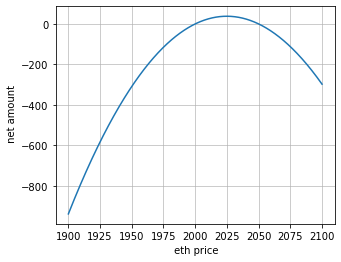

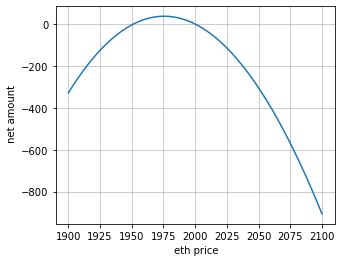

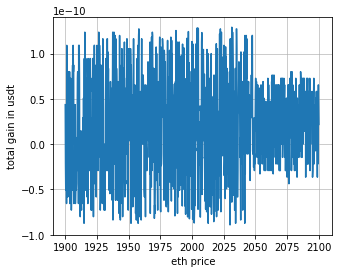

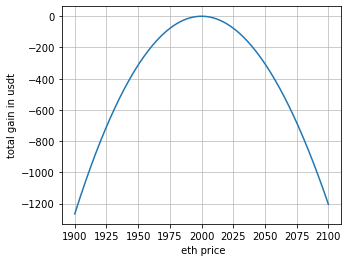

In [38]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.grid(alpha=0.8)
plt.plot(get_p1_values(), total_dx, label='pnl')
plt.xlabel(' eth price')
plt.ylabel(' net amount')
plt.figure()
plt.grid(alpha=0.8)
plt.plot(get_p1_values(), total_dy, label='pnl')
plt.xlabel(' eth price')
plt.ylabel(' net amount')
# 合约 pnl 相加
plt.figure()
plt.grid(alpha=0.8)
pnl_all = np.array(u_pnl) + np.array(bi_pnl)
plt.plot(get_p1_values(), pnl_all)
plt.xlabel(' eth price')
plt.ylabel('total gain in usdt')
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.figure()
plt.grid(alpha=0.8)
pnl_all = total_dx + total_dy
plt.plot(get_p1_values(), pnl_all)
plt.xlabel(' eth price')
plt.ylabel('total gain in usdt')
# 网格线

# 调节尺寸

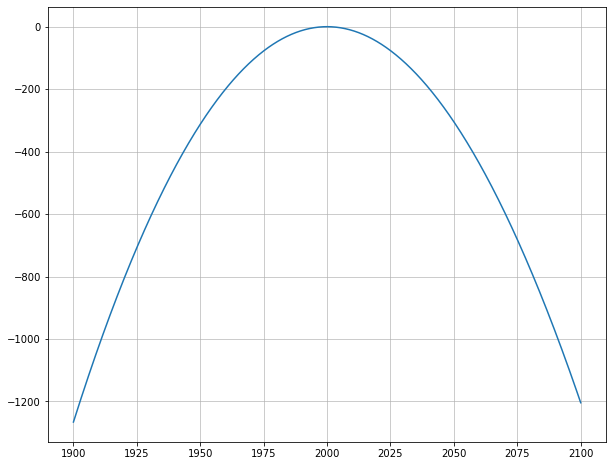

In [23]:
# impermanent loss
nakedloss = [IL(p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()]
plt.plot(get_p1_values(), nakedloss, label='nakedloss')
# 网格线
plt.grid(alpha=0.8)